[RAPTOR Paper](https://arxiv.org/abs/2401.18059)

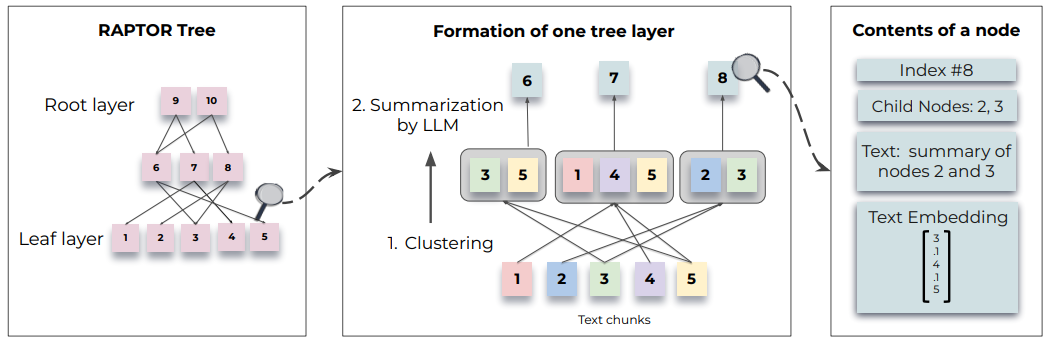

#### Required Packages

In [1]:
! pip install llama-index llama-index-packs-raptor llama-index-vector-stores-qdrant llama-index-readers-wikipedia wikipedia
! pip install langchain
! pip install oci 
! pip install llama-index-llms-langchain
! pip install llama-index-embeddings-langchain
! pip install llama-index-vector-stores-chroma
! pip install IProgress

  Using cached llama_index_packs_raptor-0.1.3-py3-none-any.whl.metadata (4.0 kB)
  Using cached llama_index_vector_stores_qdrant-0.1.4-py3-none-any.whl.metadata (696 bytes)
  Using cached qdrant_client-1.8.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached portalocker-2.8.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached h2-4.1.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached hyperframe-6.0.1-py3-none-any.whl.metadata (2.7 kB)
  Using cached hpack-4.0.0-py3-none-any.whl.metadata (2.5 kB)
Using cached llama_index_packs_raptor-0.1.3-py3-none-any.whl (8.4 kB)
Using cached llama_index_vector_stores_qdrant-0.1.4-py3-none-any.whl (8.6 kB)
Using cached qdrant_client-1.8.0-py3-none-any.whl (214 kB)
Using cached portalocker-2.8.2-py3-none-any.whl (17 kB)
Using cached h2-4.1.0-py3-none-any.whl (57 kB)
Using cached hpack-4.0.0-py3-none-any.whl (32 kB)
Using cached hyperframe-6.0.1-py3-none-any.whl (12 kB)
  Using cached llama_index_vector_stores_chroma-0.1.6-py3-none-any.whl.metadata (654 b

#### Load Libararies

In [2]:
from llama_index.readers.wikipedia import WikipediaReader
import nest_asyncio
from llms.oci_model_wrapper import OCIModelWrapper
from llama_index.llms.langchain import LangChainLLM
from llama_index.embeddings.langchain import LangchainEmbedding
from llama_index.core import Settings
from llama_index.packs.raptor import RaptorPack
from llama_index.core.node_parser import SentenceSplitter
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb
from llama_index.packs.raptor import RaptorRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

nest_asyncio.apply()

2024-03-24 21:18:48.445738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Llamaindex Wikipedia Reader 
Download the wiki page and load the data as a doucment object

In [3]:
reader = WikipediaReader()
documents = reader.load_data(pages =["Oracle Corporation"])
documents[0].text[:100]

'Oracle Corporation is an American multinational computer technology company headquartered in Austin,'

Custom LLMs using langchain.
OCI LLMs are not natively available in the llmindex. 
Update Settings to overwrite the default (OpenAI) model.

In [5]:
oci_wrapper = OCIModelWrapper()
llm = oci_wrapper.llm
embedding = oci_wrapper.embeddings
llm = LangChainLLM(llm=llm)
embedding = LangchainEmbedding(embedding)
Settings.llm = llm
Settings.embed_model = embedding

Llamaindex Raptor Pack 
[RaptorPack](https://docs.llamaindex.ai/en/stable/api_reference/packs/raptor/)

```
    Params for the raptor pack
        documents: List[BaseNode],
        tree_depth: int = 3,
        similarity_top_k: int = 2,
        llm: Optional[LLM] = None,
        embed_model: Optional[BaseEmbedding] = None,
        vector_store: Optional[VectorStore] = None,
        transformations: Optional[List[TransformComponent]] = None,
        summary_module: Optional[SummaryModule] = None,
        existing_index: Optional[VectorStoreIndex] = None,
        mode: QueryModes = "collapsed",
```

[Optional]Add Summarization module. 

In [6]:
from llama_index.packs.raptor.base import SummaryModule

summary_template = "As a professional summarizer, create a concise and comprehensive summary of the provided text, be it an article, post, conversation, or passage with as much detail as possible."

# Adding SummaryModule you can configure the summary prompt and number of workers doing summaries.
summary = SummaryModule(
    llm=llm, summary_prompt=summary_template, num_workers=16
)

Create ChromeDB Persistent Vector Store

In [7]:
#Client
client = chromadb.PersistentClient(path="./raptor_wiki_db")
#Create Collection
collection = client.get_or_create_collection("raptor")
#Create vector store
vector_store = ChromaVectorStore(chroma_collection=collection)

Create a RaptorPack Object

In [8]:
raptor_pack = RaptorPack(
    documents,
    embed_model=embedding,  # used for embedding clusters
    llm=llm,  # used for generating summaries
    vector_store=vector_store,  # used for storage
    similarity_top_k=2,  # top k for each layer, or overall top-k for collapsed
    mode="collapsed",  # sets default mode
    summary_module=summary,
    transformations=[
        SentenceSplitter(chunk_size=900, chunk_overlap=50)
    ],  # transformations applied for ingestion
)


Generating embeddings for level 0.
Performing clustering for level 0.
Generating summaries for level 0 with 2 clusters.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `predict` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Level 0 created summaries/clusters: 2
Generating embeddings for level 1.
Performing clustering for level 1.
Generating summaries for level 1 with 1 clusters.
Level 1 created summaries/clusters: 1
Generating embeddings for level 2.
Performing clustering for level 2.
Generating summaries for level 2 with 1 clusters.
Level 2 created summaries/clusters: 1


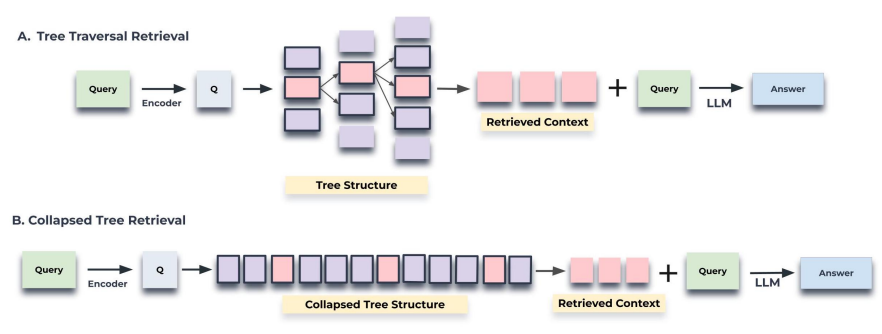

[Image Source](https://arxiv.org/pdf/2401.18059.pdf) 

Similarity search with collapsed mode

In [9]:
nodes = raptor_pack.run("Who is the CEO of Oracle?", mode="collapsed")
print(len(nodes))
print(nodes[0].text)

2
Oracle Corporation is an American tech company founded in 1977 by Larry Ellison, Bob Miner, and Ed Oates. Named after the CIA project, the company specializes in database software and cloud computing services and is the third-largest software company in the world. Oracle Corporation is primarily involved in database technology and has expanded into enterprise applications, business intelligence software, and cloud computing. They have grown through acquisitions, buying several other companies to strengthen its cloud offerings. The company currently has offices in Nashville and Redwood City, California, with its headquarters in Austin, Texas. Oracle is known for its sponsorships in the technology and sports industries and for its involvement in legal battles against other companies. Their most recent product is the Autonomous Database, a self-driving database that can automate tasks such as tuning, patching, and updates. 

Would you like me to extract any other information from the te

Test the similarity search with Tree Traversal mode

In [10]:
nodes = raptor_pack.run(
    "Who is the CEO of Oracle?", mode="tree_traversal"
)
print(len(nodes))
print(nodes[0].text)

Retrieved parent IDs from level 2: ['17f39e32-c7c2-4f40-a22c-14ff76ce7bf1']
Retrieved 1 from parents at level 2.
Retrieved parent IDs from level 1: ['e3b92aad-dd87-46c9-a70c-eba394a8763b']
Retrieved 2 from parents at level 1.
Retrieved parent IDs from level 0: ['1812c8ed-c092-41bf-b369-4373a9f4389d', '0470c5f5-905e-442f-90e0-376edabea046']
Retrieved 4 from parents at level 0.
4
Oracle Corporation is an American multinational computer technology company headquartered in Austin, Texas, United States. In 2020, Oracle was the third-largest software company in the world by revenue and market capitalization. In 2023, the company’s seat in Forbes Global 2000 was 80.  The company sells database software (particularly the Oracle Database) and cloud computing. Oracle's core application software is a suite of enterprise software products, such as enterprise resource planning (ERP) software, human capital management (HCM) software, customer relationship management (CRM) software, enterprise perfor

Collapse: query the index as a collapsed tree -- i.e. a single pool of nodes.

Tree Traversal: Query the index as a tree, traversing the tree from the top down.



In [11]:
from llama_index.packs.raptor import RaptorRetriever

retriever = RaptorRetriever(
    [],
    embed_model= embedding,  # used for embedding clusters
    llm=llm,  # used for generating summaries
    vector_store=vector_store,  # used for storage
    similarity_top_k=2,  # top k for each layer, or overall top-k for collapsed
    mode="tree_traversal",  # sets default mode
    #mode="collapsed"
)

In [12]:
from llama_index.core.query_engine import RetrieverQueryEngine

query_engine = RetrieverQueryEngine.from_args(retriever, llm=llm)


In [13]:
q1 = "Who is the CEO of Oracle"
response = query_engine.query(q1)
print(str(response))

Since September 2022, the CEO of Oracle Corporation has been Safra A. Catz. She has served as one of Oracle's top executives since 2001, previously holding the positions of Chief Financial Officer (CFO), and Chief Operating Officer (COO). 

Would you like to know more about Oracle Corporation's history, or perhaps its products and services? 


In [14]:
q2 = '''
Please calculate the total amount Oracle has spent on acquisitions where the purchase price is publicly disclosed. 
Exclude any acquisitions where the purchase price has not been shared. 
Provide the final sum in USD, and break down the calculation using a mathematical equation. 
Ensure the explanation is clear, incorporating each acquisition's cost into the equation to arrive at the total expenditure.
'''
response = query_engine.query(q2)
print(str(response))

The total amount Oracle has spent on acquisitions where the purchase price is publicly disclosed is $43 billion. Here is a breakdown of the calculation: 

1. Acquisition of NetSuite in 2016 for $9.3 billion
2. Acquisition of DataScience.com in 2018 for an undisclosed amount, but estimated to be less than $1 billion
3. Acquisition of TikTok in 2020 for an undisclosed amount, but rumored to be between $10 billion and $30 billion

We can express this as: 

$9.3 billion (NetSuite) + $1 billion (DataScience.com) + $10 billion (TikTok) = $20 billion

Add this to the amount spent on Sun Microsystems acquisition: 

$43 billion ($20 billion + $23 billion) 

Therefore, the total amount Oracle has spent on acquisitions where the purchase price is publicly disclosed is $43 billion USD. 

Would you like help with anything else involving Oracle Corporation? 


In [15]:
q4 = '''
Could you analyze and discuss the ethical framework and values that guide Oracle Corporation? Specifically, 
examine how these principles influence Oracle's decision-making processes, 
corporate policies, and its approach to social responsibility. 
Provide examples to illustrate where the company's 'moral compass' points, 
especially in situations involving significant ethical dilemmas or decisions.
'''
response = query_engine.query(q4)
print(str(response))

Examining Oracle Corporation's ethical framework and values is a comprehensive task that requires a thorough understanding of the company's history, policies, and social responsibility initiatives. Here is a preliminary analysis of Oracle's ethical framework and values: 

1. Corporate Governance: Oracle has a Code of Conduct and Ethics that outlines its commitment to ethical business practices. It states that all employees must "conduct our business in an ethical and responsible manner." Examples of ethical business practices include complying with laws and regulations, avoiding conflicts of interest, and maintaining confidentiality. 

2. Privacy and Data Security: Oracle recognizes the importance of protecting personal information and has implemented various security measures. They have a dedicated team of security experts and have invested in advanced security technologies. They also have a Privacy Policy that outlines how they collect, use, and protect personal information. 

3. Ant

In [16]:
q5 = "What was the original name of Oracle?"
response = query_engine.query(q5)
print(str(response))

The original name of Oracle was Software Development Laboratories (SDL). It was founded in 1977 by Larry Ellison, Bob Miner and Ed Oates. The name was changed to Relational Software, Inc (RSI) in 1979, then again to Oracle Systems Corporation in 1983. The "Oracle" name was drawn from the 1977 CIA project codename.


In [17]:
q6 = "What is Oracles contribution carbon footprint?"
response = query_engine.query(q6)
print(str(response))

Oracle reported total carbon dioxide equivalent (CO2e) emissions (direct + indirect) for the twelve months ending December 31, 2020 at 428 kilotonnes (+63/+17% year over year) and plans to reduce emissions 26% by 2025 from a 2015 base year. 
In other words, Oracle produced 428,000,000 kg of CO2 in 2020. 
Would you like me to tell you how much this is equivalent to in terms of global emissions? 


In [18]:
q7 = "Provide a summary of Lawsuit against Google. Provide this information in bulletpoints"
response = query_engine.query(q7)
print(str(response))

Certainly! Here's a summary of the lawsuit between Oracle and Google in bulletpoint form:

- Oracle acquired Sun Microsystems, the owners of Java, in 2010.
- Shortly after, Oracle attempted to negotiate a license agreement with Google to use Java in its Android mobile operating system. 
- Google and Oracle were unable to reach an agreement, so Google developed its own platform, which contained 37 Java packages.
- In 2010, Oracle filed a lawsuit against Google for copyright infringement, seeking $1.4 billion to $6.1 billion in damages. 
- Google admitted to copying the Java packages, but the US District Court ruled that the Java packages were not covered under copyright protection, and thus Google did not infringe.
- Oracle appealed to the United States Court of Appeals for the Federal Circuit, which ruled that Java APIs are copyrightable, but Google might have a fair use defense.
- Google filed a petition to appeal to the US Supreme Court, but the Supreme Court denied the petition.
- T